# Natural Language Processing for Stock Price

## Download Stopwords

In [6]:
import nltk

In [7]:
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords
        C:\Users\Apocrypse\AppData\Roaming\nltk_data...
      Unzipping corpora\stopwords.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


## Get the Data

In [8]:
import pandas as pd

In [21]:
news = pd.read_csv('Reuters.csv')
news.head()

,Date,Content
0,20170101,Peruvian president Pedro Pablo Kuczynski said ...
1,20170102,U.S. officials are urgentlyseeking an agreemen...
2,20170103,Hong Leong Bank Bhd :Goertek IncLandsea Green ...
3,20170104,Japanese government bond pricesslipped on Wedn...
4,20170105,Meda Inc BhdUnited Bank of IndiaFord Motor :Fo...


In [31]:
signal = pd.read_csv('Signal.csv')
signal.head()

,Date,Adj Close,Price Chg,Signal
0,20170103,2257.830078,0.005722,Buy
1,20170104,2270.750000,-0.000771,Sell
2,20170105,2269.000000,0.003517,Buy
3,20170106,2276.979980,-0.003549,Sell
4,20170109,2268.899902,0.000000,Excluded


In [36]:
df = pd.merge(signal, news, on='Date')
df.head()

,Date,Adj Close,Price Chg,Signal,Content
0,20170103,2257.830078,0.005722,Buy,Hong Leong Bank Bhd :Goertek IncLandsea Green ...
1,20170104,2270.750000,-0.000771,Sell,Japanese government bond pricesslipped on Wedn...
2,20170105,2269.000000,0.003517,Buy,Meda Inc BhdUnited Bank of IndiaFord Motor :Fo...
3,20170106,2276.979980,-0.003549,Sell,Toshiba Corp plans to meet with creditor banks...
4,20170109,2268.899902,0.000000,Excluded,Citic Ltd :Here are some factors that mayaffec...


In [37]:
df.drop(['Date', 'Adj Close', 'Price Chg'], axis=1, inplace=True)
df.dropna(axis=0, inplace=True)
df.describe()

,Signal,Content
count,290,290
unique,3,290
top,Buy,"BlackRock Inc, the world's largest asset manag..."
freq,166,1


In [39]:
df['Signal'].unique()

array(['Buy', 'Sell', 'Excluded'], dtype=object)

In [41]:
df[df['Signal'] == 'Excluded']

,Signal,Content
4,Excluded,Citic Ltd :Here are some factors that mayaffec...


In [42]:
df.drop(4, axis=0, inplace=True)

In [43]:
df[df['Signal'] == 'Excluded']

,Signal,Content


In [47]:
df.describe()

,Signal,Content
count,289,289
unique,2,289
top,Buy,"BlackRock Inc, the world's largest asset manag..."
freq,166,1


## Exploratory Data Analysis

In [48]:
df.groupby('Signal').describe()

Content                                                               
         count unique                                                top freq
Signal                                                                       
Buy        166    166  Thai commercial banks' loans mayincrease 6-8 p...    1
Sell       123    123  Australia's Westpac BankingCorp said on Friday...    1

In [49]:
df['Length'] = df['Content'].apply(len)

In [50]:
df.head()

,Signal,Content,Length
0,Buy,Hong Leong Bank Bhd :Goertek IncLandsea Green ...,52250
1,Sell,Japanese government bond pricesslipped on Wedn...,124466
2,Buy,Meda Inc BhdUnited Bank of IndiaFord Motor :Fo...,148164
3,Sell,Toshiba Corp plans to meet with creditor banks...,184591
5,Buy,Most Southeast Asian stock markets roseon Tues...,191614


In [51]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

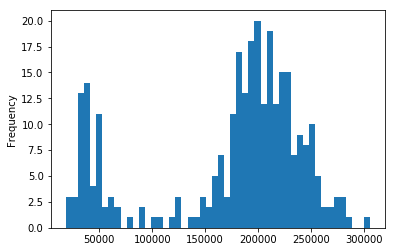

In [52]:
df['Length'].plot.hist(bins=50)

In [54]:
df['Length'].describe()

count       289.000000
mean     174296.325260
std       72457.497189
min       18489.000000
25%      157560.000000
50%      196200.000000
75%      223729.000000
max      305570.000000
Name: Length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022D03E06B70>,
      dtype=object)

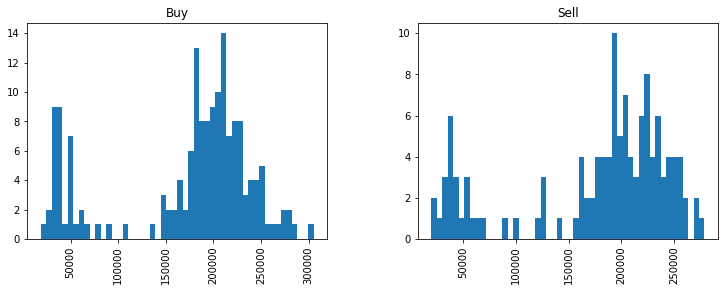

In [55]:
df.hist(column='Length', by='Signal', bins=50, figsize=(12,4))

## Pre-process

In [56]:
import string

In [60]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [63]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [64]:
def textProcess(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Stem all words
    4. Returns a list of the cleaned text
    :type mess: str
    :rtype: List[str]
    """
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [ps.stem(word) for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [65]:
df['Content'].head().apply(textProcess)

0    [hong, leong, bank, bhd, goertek, inclandsea, ...
1    [japanes, govern, bond, pricesslip, wednesday,...
2    [meda, inc, bhdunit, bank, indiaford, motor, f...
3    [toshiba, corp, plan, meet, creditor, bank, tu...
5    [southeast, asian, stock, market, roseon, tues...
Name: Content, dtype: object

## Vectorization and Sparsity

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer=textProcess).fit(df['Content'])
print(len(bow_transformer.vocabulary_))

412107


In [70]:
bow = bow_transformer.transform(df['Content'])
print('Shape of Sparse Matrix: ', bow.shape)
print('Amount of Non-Zero occurences: ', bow.nnz)

Shape of Sparse Matrix:  (289, 412107)
Amount of Non-Zero occurences:  1588567


In [74]:
sparsity = (100.0 * bow.nnz / (bow.shape[0] * bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 1


## Train Test Split

In [76]:
from sklearn.model_selection import train_test_split
cnt_train, cnt_test, signal_train, signal_test = train_test_split(df['Content'], df['Signal'], test_size=0.2, random_state=35)

In [77]:
train_bow_transformer = CountVectorizer(analyzer=textProcess).fit(cnt_train)
train_bow = train_bow_transformer.transform(cnt_train)
test_bow = train_bow_transformer.transform(cnt_test)

## TF-IDF

In [78]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(train_bow)
train_tfidf = tfidf_transformer.transform(train_bow)
test_tfidf = tfidf_transformer.transform(test_bow)

## Naive Bayes

In [80]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(train_tfidf, signal_train)
mnb_pred = mnb.predict(test_tfidf)

In [93]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(signal_test, mnb_pred))
print(classification_report(signal_test, mnb_pred))

[[31  0]
 [27  0]]
             precision    recall  f1-score   support

        Buy       0.53      1.00      0.70        31
       Sell       0.00      0.00      0.00        27

avg / total       0.29      0.53      0.37        58



D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## K-Nearest Neighbors

In [88]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
error_rate = []
for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_tfidf, signal_train)
    knn_pred = knn.predict(test_tfidf)
    error_rate.append(np.mean(signal_test != knn_pred))

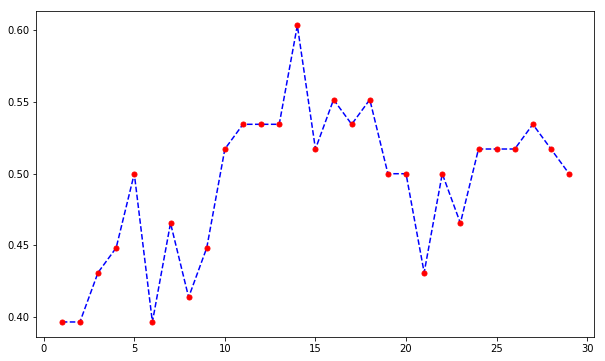

In [90]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30), error_rate, c='blue', ls='--', marker='o', mfc='red',mec='red', ms=5)

In [94]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(train_tfidf, signal_train)
knn_pred = knn.predict(test_tfidf)

In [95]:
print(confusion_matrix(signal_test, knn_pred))
print(classification_report(signal_test, knn_pred))

[[27  4]
 [19  8]]
             precision    recall  f1-score   support

        Buy       0.59      0.87      0.70        31
       Sell       0.67      0.30      0.41        27

avg / total       0.62      0.60      0.57        58



## Random Forests

In [104]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50)
rf.fit(train_tfidf, signal_train)
rf_pred = rf.predict(test_tfidf)

In [99]:
print(confusion_matrix(signal_test, rf_pred))
print(classification_report(signal_test, rf_pred))

[[29  2]
 [24  3]]
             precision    recall  f1-score   support

        Buy       0.55      0.94      0.69        31
       Sell       0.60      0.11      0.19        27

avg / total       0.57      0.55      0.46        58



## Support Vector Machine

In [105]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}

In [107]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

In [108]:
grid.fit(train_tfidf, signal_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV]  C=0.01, gamma=10, kernel=rbf, score=0.5844155844155844, total=   1.8s
[CV] C=0.01, gamma=10, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV]  C=0.01, gamma=10, kernel=rbf, score=0.5844155844155844, total=   1.8s
[CV] C=0.01, gamma=10, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s


[CV]  C=0.01, gamma=10, kernel=rbf, score=0.5844155844155844, total=   1.8s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV]  C=0.01, gamma=1, kernel=rbf, score=0.5844155844155844, total=   1.9s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV]  C=0.01, gamma=1, kernel=rbf, score=0.5844155844155844, total=   1.8s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV]  C=0.01, gamma=1, kernel=rbf, score=0.5844155844155844, total=   1.8s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV]  C=0.01, gamma=0.1, kernel=rbf, score=0.5844155844155844, total=   1.6s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV]  C=0.01, gamma=0.1, kernel=rbf, score=0.5844155844155844, total=   1.6s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV]  C=0.01, gamma=0.1, kernel=rbf, score=0.5844155844155844, total=   1.6s
[CV] C=0.01, gamma=0.01, kernel=rbf ......

[CV]  C=10, gamma=1, kernel=rbf, score=0.4805194805194805, total=   1.8s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV]  C=10, gamma=1, kernel=rbf, score=0.5194805194805194, total=   1.8s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV]  C=10, gamma=0.1, kernel=rbf, score=0.5714285714285714, total=   1.8s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV]  C=10, gamma=0.1, kernel=rbf, score=0.5714285714285714, total=   1.8s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV]  C=10, gamma=0.1, kernel=rbf, score=0.5584415584415584, total=   1.8s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV]  C=10, gamma=0.01, kernel=rbf, score=0.5844155844155844, total=   1.8s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV]  C=10, gamma=0.01, kernel=rbf, score=0.5844155844155844, total=   1.8s
[CV] C=10, gamma=0.01, kernel=rbf .................

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  5.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [109]:
grid.best_params_

{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}

In [110]:
svm_pred = grid.predict(test_tfidf)

In [111]:
print(confusion_matrix(signal_test, knn_pred))
print(classification_report(signal_test, knn_pred))

[[27  4]
 [19  8]]
             precision    recall  f1-score   support

        Buy       0.59      0.87      0.70        31
       Sell       0.67      0.30      0.41        27

avg / total       0.62      0.60      0.57        58



## Neural Network 

In [120]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20), random_state=135)
nn.fit(train_tfidf, signal_train)
nn_pred = nn.predict(test_tfidf)

In [121]:
print(confusion_matrix(signal_test, nn_pred))
print(classification_report(signal_test, nn_pred))

[[23  8]
 [20  7]]
             precision    recall  f1-score   support

        Buy       0.53      0.74      0.62        31
       Sell       0.47      0.26      0.33        27

avg / total       0.50      0.52      0.49        58

